# Using a Neural Network to Predict Metabolic Syndrome


*Chrisitina Brockway*

### Load Data and Imports

In [1]:
#Basic Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Preprocessing tools
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

# Deep learning tools
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

#Evaluation tools
from sklearn.metrics import mean_absolute_error, r2_score, \
mean_squared_error, precision_score, recall_score, accuracy_score, f1_score, \
confusion_matrix, classification_report
from tensorflow import metrics

from sklearn import set_config, config_context
set_config(transform_output='pandas')
pd.set_option("display.max_rows", 999)
pd.set_option("display.max_columns", 999)

# Set random seeds for consistent outcomes
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
# Custom function for plotting each metric
def plot_history(history, figsize=(6,12), marker='o'):
       
    # Get list of metrics from history
    metrics = [c for c in history.history if not c.startswith('val_')]
    
    ## Separate row for each metric
    fig, axes = plt.subplots(nrows=len(metrics),figsize=figsize)
    
    # For each metric
    for i, metric_name in enumerate(metrics):
    
        # Get the axis for the current metric
        ax = axes[i]
    
        # Get metric from history.history
        metric_values = history.history[metric_name]
        # Get epochs from history
        epochs = history.epoch
    
        # Plot the training metric
        ax.plot(epochs, metric_values, label=metric_name, marker=marker)
    
        ## Check if val_{metric} exists. if so, plot:
        val_metric_name = f"val_{metric_name}"
        if val_metric_name in history.history:
            # Get validation values and plot
            metric_values = history.history[val_metric_name]
            ax.plot(epochs,metric_values,label=val_metric_name, marker=marker)
    
        # Final subplot adjustments 
        ax.legend()
        ax.set_title(metric_name)
    fig.tight_layout()

    return fig, axes


In [3]:
df= pd.read_csv('data/clean_MetS.csv', index_col='seqn')
df.head()

,Age,Sex,Marital,Income,Race,Waist,BMI,AlbRating,UricAcid,Glucose,HDL,Triglycerides,MetS
seqn,,,,,,,,,,,,,
62161,22,Male,Single,8200.0,White,81.0,23.3,0,4.9,92,41,84,No MetSyn
62164,44,Female,Married,4500.0,White,80.1,23.2,0,4.5,82,28,56,No MetSyn
62169,21,Male,Single,800.0,Asian,69.6,20.1,0,5.4,107,43,78,No MetSyn
62172,43,Female,Single,2000.0,Black,120.4,33.3,0,5.0,104,73,141,No MetSyn
62177,51,Male,Married,NaN,Asian,81.1,20.1,0,5.0,95,43,126,No MetSyn


In [4]:
df.duplicated().sum()

0

In [5]:
df.isna().sum()

Age                0
Sex                0
Marital          208
Income           117
Race               0
Waist             85
BMI               26
AlbRating          0
UricAcid           0
Glucose            0
HDL                0
Triglycerides      0
MetS               0
dtype: int64

*  Since target is string will need need to replce values with 0 for no metabolic syndrome and 1 for Metabolic syndrome

In [6]:
df['MetS']=df['MetS'].replace({'No MetSyn': 0, 'MetSyn': 1})
df['MetS'].value_counts()

0    1579
1     822
Name: MetS, dtype: int64

### Preprocess Data for Machine Learning

In [7]:
# Train Test Split
X= df.drop(columns='MetS')
y=df['MetS']

X_train, X_test, y_train, y_test = train_test_split(X,y)

In [8]:
X_train.head()

,Age,Sex,Marital,Income,Race,Waist,BMI,AlbRating,UricAcid,Glucose,HDL,Triglycerides
seqn,,,,,,,,,,,,
63211,46,Female,Married,8200.0,White,124.0,40.8,0,3.3,140,53,198
70548,34,Male,Separated,3500.0,MexAmerican,86.2,24.5,0,6.1,114,83,60
64722,33,Female,Married,3500.0,MexAmerican,75.0,25.0,0,3.4,97,44,60
69237,49,Female,Married,9000.0,Hispanic,95.7,33.3,0,2.7,89,51,139
65286,30,Male,Married,9000.0,Asian,75.7,21.9,0,7.1,81,58,394


In [9]:
cat_col= X_train.select_dtypes('object').columns
num_col= X_train.select_dtypes('number').columns

In [10]:
#Instantiate the transformers
from sklearn.impute import KNNImputer
scaler=StandardScaler()
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
knnimpute= KNNImputer(n_neighbors=3)
oheimpute = SimpleImputer(strategy='constant', fill_value='none')

In [11]:
#Create pipelines
num_pipe= make_pipeline(knnimpute, scaler)
cat_pipe= make_pipeline(oheimpute, ohe)

In [12]:
num_tuple= ("Numeric", num_pipe, num_col)
cat_tuple=("Catagorical", cat_pipe, cat_col)

preprocessor = ColumnTransformer([num_tuple, cat_tuple], remainder='passthrough')

In [13]:
preprocessor.fit(X_train)
X_train_tf=preprocessor.transform(X_train)
X_test_tf=preprocessor.transform(X_test)

### Build Model 1

In [14]:
# Save the number of features we have as our input shape
input_shape = X_train_tf.shape[1]
input_shape

23

In [15]:
# Step 1 Build Network Structure

# Sequential model
model = keras.Sequential()

model.add(Dense(20, input_dim=input_shape, activation ='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation = 'sigmoid'))

#Step 2: compile
model.compile(loss = 'bce', optimizer = 'adam'
              ,metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                480       
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 701
Trainable params: 701
Non-trainable params: 0
_________________________________________________________________


In [16]:
# Use Early Stopping callback
early_stop = EarlyStopping(monitor='val_accuracy', patience=5)

In [17]:
history = model.fit(X_train_tf, y_train,
                        validation_split=.2,
                        epochs=50, callbacks = [early_stop])

Epoch 1/50
45/45 [==============================] - 1s 9ms/step - loss: 0.6156 - accuracy: 0.6729 - val_loss: 0.5872 - val_accuracy: 0.6500
Epoch 2/50
45/45 [==============================] - 0s 2ms/step - loss: 0.5261 - accuracy: 0.7028 - val_loss: 0.5109 - val_accuracy: 0.7111
Epoch 3/50
45/45 [==============================] - 0s 2ms/step - loss: 0.4683 - accuracy: 0.7521 - val_loss: 0.4569 - val_accuracy: 0.7750
Epoch 4/50
45/45 [==============================] - 0s 2ms/step - loss: 0.4281 - accuracy: 0.7979 - val_loss: 0.4135 - val_accuracy: 0.8000
Epoch 5/50
45/45 [==============================] - 0s 2ms/step - loss: 0.3982 - accuracy: 0.8160 - val_loss: 0.3812 - val_accuracy: 0.8361
Epoch 6/50
45/45 [==============================] - 0s 2ms/step - loss: 0.3785 - accuracy: 0.8229 - val_loss: 0.3615 - val_accuracy: 0.8333
Epoch 7/50
45/45 [==============================] - 0s 2ms/step - loss: 0.3644 - accuracy: 0.8299 - val_loss: 0.3511 - val_accuracy: 0.8389
Epoch 8/50
45/45 [==

(<Figure size 600x1200 with 2 Axes>,
 array([<Axes: title={'center': 'loss'}>,
        <Axes: title={'center': 'accuracy'}>], dtype=object))

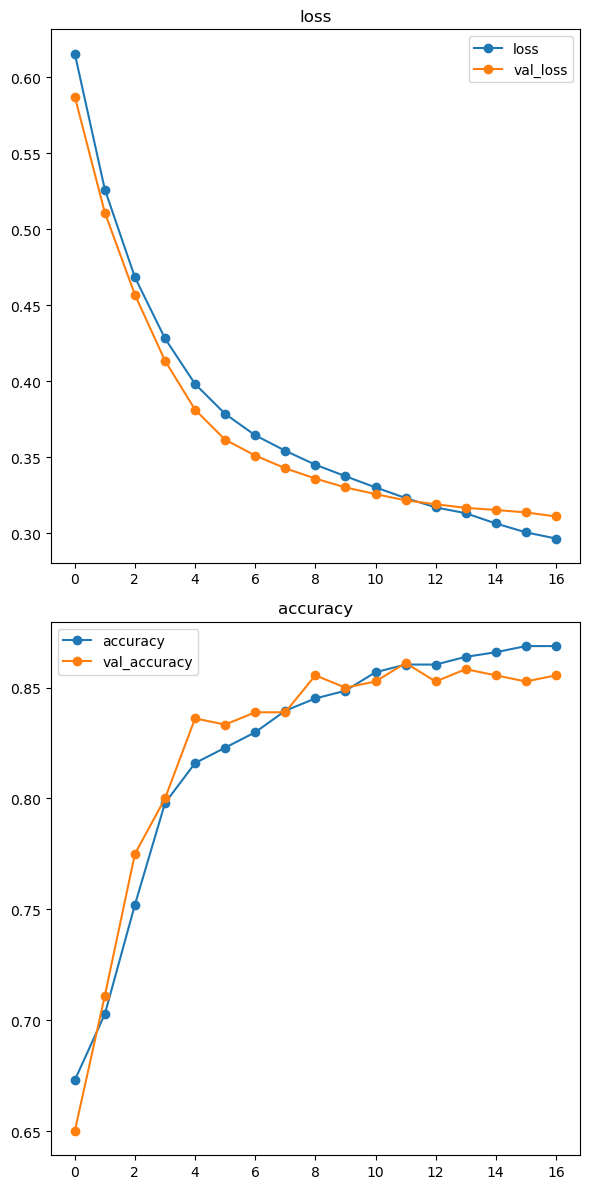

In [18]:
# Apply the custom function plot_history() to see how your model is doing
plot_history(history)

In [19]:
result=model.evaluate(X_test_tf, y_test, return_dict=True)
result

19/19 [==============================] - 0s 2ms/step - loss: 0.3580 - accuracy: 0.8319


{'loss': 0.35801735520362854, 'accuracy': 0.8319467306137085}

19/19 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.87      0.87      0.87       397
           1       0.75      0.75      0.75       204

    accuracy                           0.83       601
   macro avg       0.81      0.81      0.81       601
weighted avg       0.83      0.83      0.83       601



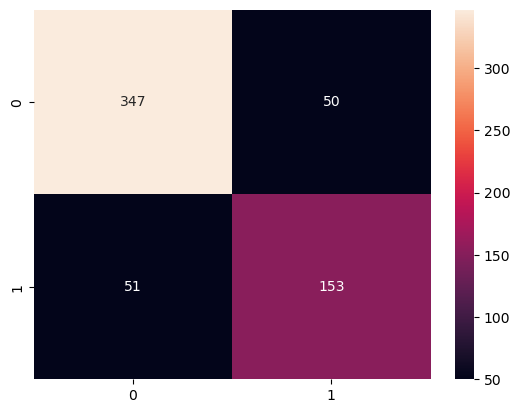

In [20]:
#evaluate with sklearn metrics
test_preds = model.predict(X_test_tf).round()
print(classification_report(y_test, test_preds))
conf_mat = confusion_matrix(y_test, test_preds)
sns.heatmap(conf_mat, annot=True, fmt='g');

## Model 2 Tune Parameters with Keras Tuner 

Source:
https://keras.io/guides/keras_tuner/getting_started/

In [21]:
from keras_tuner import HyperParameters as hp
import keras_tuner as kt


In [22]:
# Step 1 Build Network Structure

# Sequential model
def build_model(hp):
    units = hp.Int("units", min_value=32, max_value=512, step=32)
    opitimizers = hp.Choice('optimizer', ['rmsprop','nadam','adam'])
    dropout= hp.Boolean('dropout')   
   
    model2 = Sequential()
    model2.add(Dense(units=units, activation ='relu'))
  
    if dropout:
           model2.add(Dropout(.2))
                  
    model2.add(Dense(1, activation = 'sigmoid'))

#Step 2: compile
    model2.compile(loss = 'bce', optimizer = opitimizers,
                      metrics=['accuracy'])
    
    return model2

In [23]:
model2= build_model(kt.HyperParameters())

In [24]:
# Use Early Stopping callback
early_stop = EarlyStopping(monitor='val_accuracy', patience=5)

In [25]:
history2 = model2.fit(X_train_tf, y_train,
                        validation_split=.2,
                        epochs=50, callbacks = [early_stop])

Epoch 1/50
45/45 [==============================] - 1s 8ms/step - loss: 0.5977 - accuracy: 0.6958 - val_loss: 0.5092 - val_accuracy: 0.7944
Epoch 2/50
45/45 [==============================] - 0s 2ms/step - loss: 0.4545 - accuracy: 0.8014 - val_loss: 0.4217 - val_accuracy: 0.8194
Epoch 3/50
45/45 [==============================] - 0s 2ms/step - loss: 0.3963 - accuracy: 0.8257 - val_loss: 0.3826 - val_accuracy: 0.8417
Epoch 4/50
45/45 [==============================] - 0s 2ms/step - loss: 0.3691 - accuracy: 0.8354 - val_loss: 0.3645 - val_accuracy: 0.8361
Epoch 5/50
45/45 [==============================] - 0s 2ms/step - loss: 0.3522 - accuracy: 0.8417 - val_loss: 0.3514 - val_accuracy: 0.8444
Epoch 6/50
45/45 [==============================] - 0s 2ms/step - loss: 0.3409 - accuracy: 0.8444 - val_loss: 0.3482 - val_accuracy: 0.8306
Epoch 7/50
45/45 [==============================] - 0s 2ms/step - loss: 0.3331 - accuracy: 0.8493 - val_loss: 0.3414 - val_accuracy: 0.8361
Epoch 8/50
45/45 [==

(<Figure size 600x1200 with 2 Axes>,
 array([<Axes: title={'center': 'loss'}>,
        <Axes: title={'center': 'accuracy'}>], dtype=object))

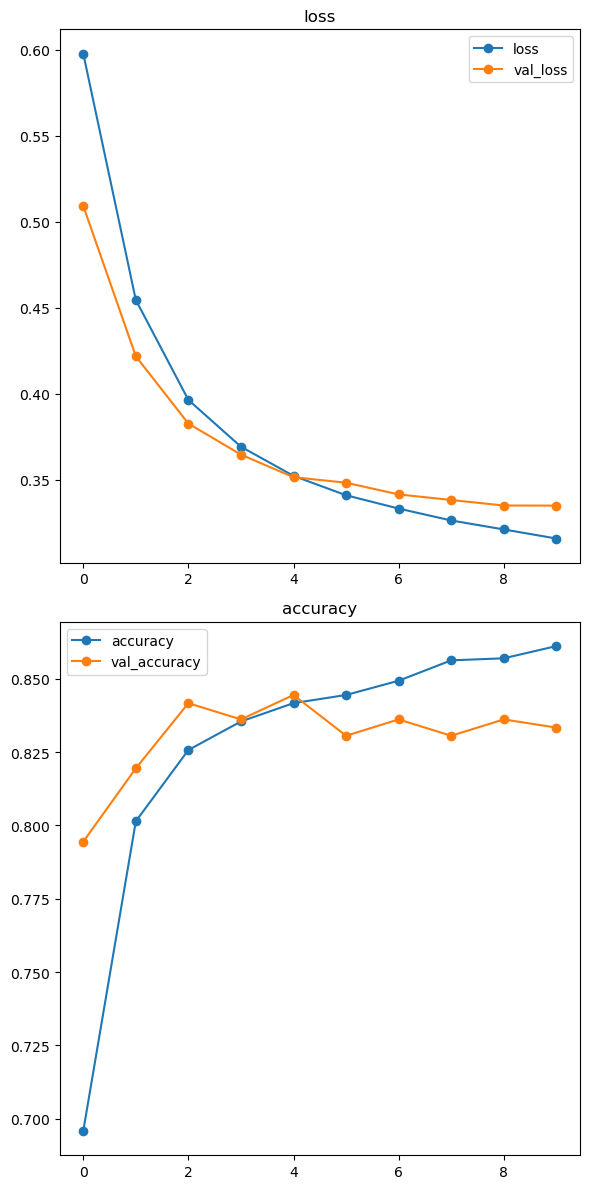

In [26]:
# Apply the custom function plot_history() to see how your model is doing
plot_history(history2)

In [27]:
result=model2.evaluate(X_test_tf, y_test, return_dict=True)
result

19/19 [==============================] - 0s 1ms/step - loss: 0.3576 - accuracy: 0.8286


{'loss': 0.3576037287712097, 'accuracy': 0.8286189436912537}

19/19 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.85      0.90      0.87       397
           1       0.79      0.68      0.73       204

    accuracy                           0.83       601
   macro avg       0.82      0.79      0.80       601
weighted avg       0.83      0.83      0.83       601



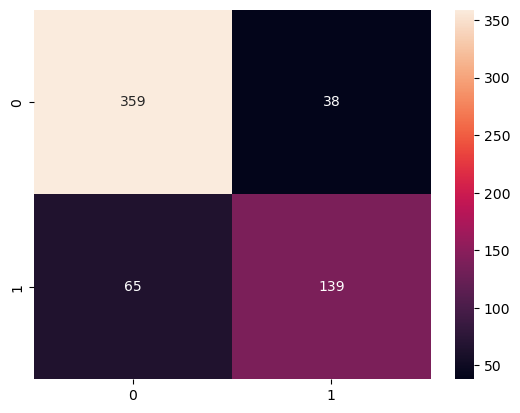

In [28]:
#evaluate with sklearn metrics
test_preds2 = model2.predict(X_test_tf).round()
print(classification_report(y_test, test_preds2))
conf_mat = confusion_matrix(y_test, test_preds2)
sns.heatmap(conf_mat, annot=True, fmt='g');

#  Evaluate Model

Both models performed about the same.  The plot shows there is a point (different for both models) where the model becomes overfit.  Perhaps using a lower patience during early stopping would prevent this. I would choose model 1 because the models perform approximately the same, but model 1 is less complicated.